# Comprehensive ML Exploration for Midterm Report

This notebook explores multiple machine learning techniques to:
1. **Discover patterns** in NBA player performance data
2. **Compare methods** for predicting PTS, REB, AST
3. **Evaluate effectiveness** of different approaches

**Techniques explored:**
- Clustering: K-Means, K-Means++, Hierarchical, DBSCAN
- Dimensionality Reduction: PCA, SVD
- Regression: Linear, Ridge/Lasso, Decision Tree, Random Forest, XGBoost, SVM, Neural Network
- Classification: Logistic Regression, Naive Bayes, SVM
- Evaluation: Cross-validation, residual analysis, feature importance

## Setup and Data Loading

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor, XGBClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [36]:
# Load enhanced features from notebook 05
df = pd.read_parquet('../data/processed/features_enhanced.parquet')

print(f"Dataset: {len(df)} games, {len(df.columns)} columns")
print(f"Date range: {df['GAME_DATE'].min()} to {df['GAME_DATE'].max()}")
print(f"Players: {df['PLAYER_ID'].nunique()}")

# Time-based split (same as notebook 05)
train = df[df['GAME_DATE'] < '2024-01-01']
test = df[df['GAME_DATE'] >= '2024-01-01']

print(f"\nTrain: {len(train)} games ({train['GAME_DATE'].min()} to {train['GAME_DATE'].max()})")
print(f"Test: {len(test)} games ({test['GAME_DATE'].min()} to {test['GAME_DATE'].max()})")

Dataset: 2959 games, 51 columns
Date range: 2023-10-26 00:00:00 to 2024-04-14 00:00:00
Players: 44

Train: 1174 games (2023-10-26 00:00:00 to 2023-12-31 00:00:00)
Test: 1785 games (2024-01-01 00:00:00 to 2024-04-14 00:00:00)


---
# Section 1: Player Segmentation via Clustering

**Goal:** Discover natural groupings of players based on their performance profiles.

**Methods:**
- K-Means / K-Means++ (partitional clustering)
- Hierarchical Clustering (agglomerative)
- DBSCAN (density-based)

**Use Case:** Understanding if different player archetypes (scorers, rebounders, playmakers) require different prediction models.

In [37]:
# Aggregate player statistics (season averages)
player_stats = train.groupby('PLAYER_ID').agg({
    'PTS': 'mean',
    'REB': 'mean',
    'AST': 'mean',
    'MIN': 'mean',
    'FGA': 'mean',
    'FG3A': 'mean',
    'FTA': 'mean',
    'FG_PCT': 'mean'
}).reset_index()

print(f"Player profiles: {len(player_stats)} players")
print("\nSample statistics:")
print(player_stats.describe())

Player profiles: 44 players

Sample statistics:
          PLAYER_ID        PTS        REB        AST        MIN        FGA  \
count  4.400000e+01  44.000000  44.000000  44.000000  44.000000  44.000000   
mean   1.143240e+06  21.704921   5.991242   5.007087  32.231009  15.840638   
std    6.841411e+05   6.529255   2.797982   2.455450   4.409026   4.285644   
min    2.011420e+05  10.111111   2.466667   0.913043  19.086957   6.740741   
25%    2.034972e+05  16.854587   4.027778   3.572660  29.912069  12.038462   
50%    1.628384e+06  22.104455   5.127946   4.566717  34.088542  17.064516   
75%    1.629656e+06  26.084229   6.925000   6.000000  35.016129  19.160839   
max    1.641706e+06  35.416667  12.483871  12.814815  37.200000  23.689655   

            FG3A        FTA     FG_PCT  
count  44.000000  44.000000  44.000000  
mean    4.993507   5.099156   0.496544  
std     2.840005   2.501400   0.054265  
min     0.000000   1.206897   0.406100  
25%     3.243175   3.219355   0.458037  
50%

## 1.1 K-Means Clustering

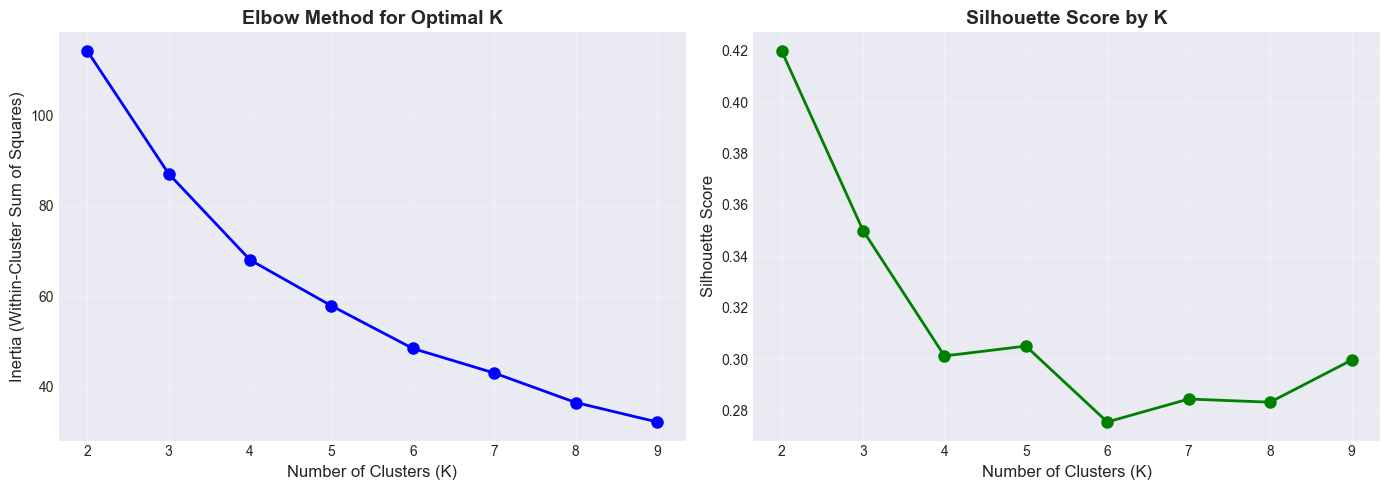

K-Means Evaluation:
  K=2: Inertia=114.22, Silhouette=0.420
  K=3: Inertia=87.09, Silhouette=0.350
  K=4: Inertia=68.05, Silhouette=0.301
  K=5: Inertia=57.91, Silhouette=0.305
  K=6: Inertia=48.49, Silhouette=0.276
  K=7: Inertia=43.07, Silhouette=0.284
  K=8: Inertia=36.55, Silhouette=0.283
  K=9: Inertia=32.26, Silhouette=0.300


In [38]:
# Prepare features for clustering
clustering_features = ['PTS', 'REB', 'AST', 'MIN', 'FGA']
X_cluster = player_stats[clustering_features].values

# Scale features (critical for distance-based clustering)
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Elbow method to find optimal K
inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=RANDOM_SEED, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by K', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/kmeans_elbow_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()

print("K-Means Evaluation:")
for k, inertia, sil in zip(K_range, inertias, silhouette_scores):
    print(f"  K={k}: Inertia={inertia:.2f}, Silhouette={sil:.3f}")

In [39]:
# Choose optimal K (based on elbow + silhouette)
optimal_k = 4  # Typical NBA archetypes: Superstars, Scorers, Role Players, Bench

kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=RANDOM_SEED, n_init=10)
player_stats['cluster_kmeans'] = kmeans_final.fit_predict(X_cluster_scaled)

# Analyze clusters
print(f"\nK-Means Clustering Results (K={optimal_k}):")
print("="*70)

for cluster_id in range(optimal_k):
    cluster_players = player_stats[player_stats['cluster_kmeans'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_players)} players):")
    print(f"  Avg PTS: {cluster_players['PTS'].mean():.1f}")
    print(f"  Avg REB: {cluster_players['REB'].mean():.1f}")
    print(f"  Avg AST: {cluster_players['AST'].mean():.1f}")
    print(f"  Avg MIN: {cluster_players['MIN'].mean():.1f}")


K-Means Clustering Results (K=4):

Cluster 0 (11 players):
  Avg PTS: 27.7
  Avg REB: 5.0
  Avg AST: 7.7
  Avg MIN: 35.9

Cluster 1 (12 players):
  Avg PTS: 13.4
  Avg REB: 5.5
  Avg AST: 2.9
  Avg MIN: 26.2

Cluster 2 (7 players):
  Avg PTS: 26.8
  Avg REB: 10.8
  Avg AST: 5.5
  Avg MIN: 34.8

Cluster 3 (14 players):
  Avg PTS: 21.5
  Avg REB: 4.8
  Avg AST: 4.5
  Avg MIN: 33.2


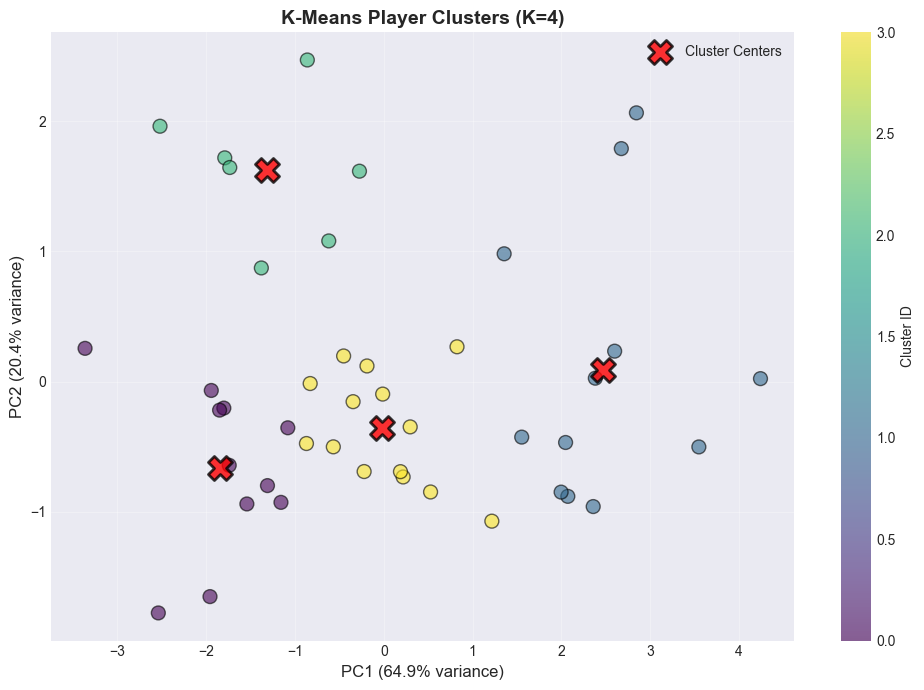

In [40]:
# Visualize clusters in 2D (PCA projection)
pca_2d = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca_2d = pca_2d.fit_transform(X_cluster_scaled)

fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=player_stats['cluster_kmeans'], 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black')

# Plot cluster centers
centers_pca = pca_2d.transform(kmeans_final.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', s=300, alpha=0.8, marker='X', edgecolors='black', linewidths=2,
           label='Cluster Centers')

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title(f'K-Means Player Clusters (K={optimal_k})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.colorbar(scatter, ax=ax, label='Cluster ID')
plt.tight_layout()
plt.savefig('../reports/figures/kmeans_clusters_2d.png', dpi=150, bbox_inches='tight')
plt.show()

## 1.2 Hierarchical Clustering

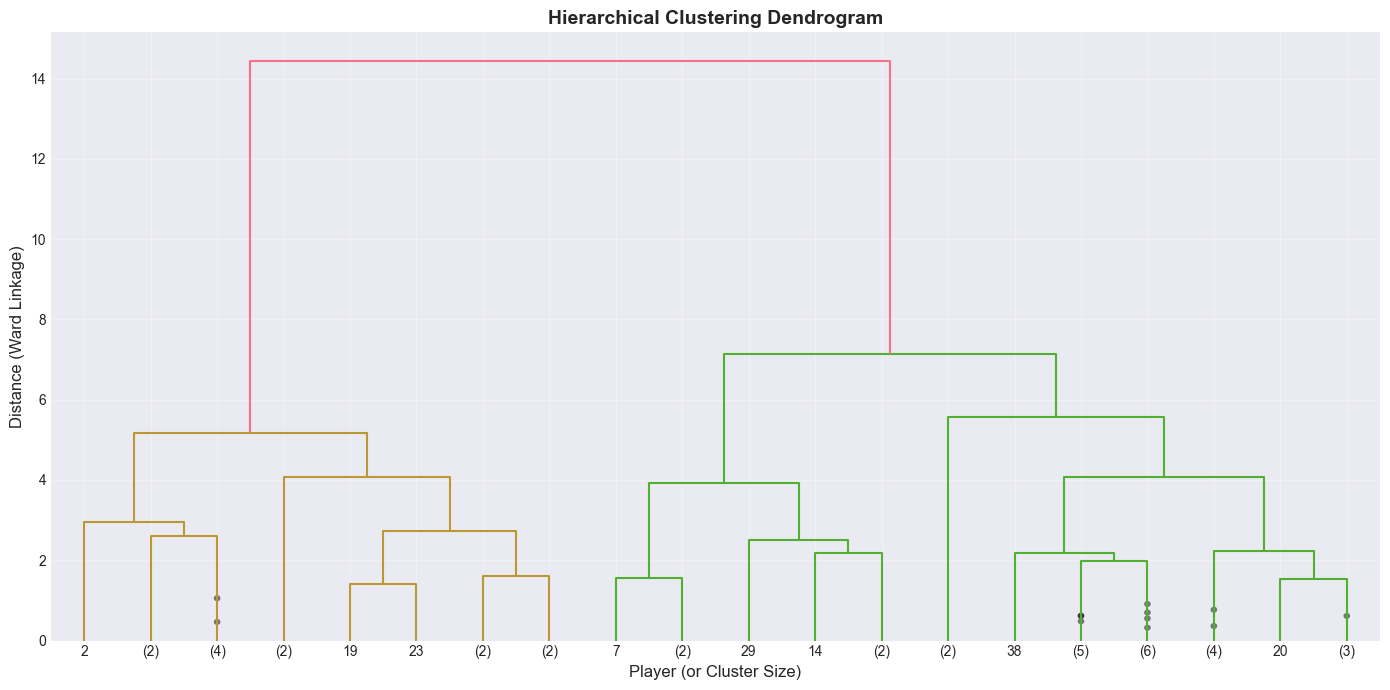


Hierarchical Clustering Results (K=4):
Cluster distribution: {0: 15, 1: 20, 2: 7, 3: 2}


In [41]:
# Compute linkage matrix
linkage_matrix = linkage(X_cluster_scaled, method='ward')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(14, 7))

dendrogram(linkage_matrix, ax=ax, truncate_mode='lastp', p=20, 
           leaf_font_size=10, show_contracted=True)

ax.set_xlabel('Player (or Cluster Size)', fontsize=12)
ax.set_ylabel('Distance (Ward Linkage)', fontsize=12)
ax.set_title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/hierarchical_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

# Fit hierarchical clustering with same K as K-Means for comparison
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
player_stats['cluster_hierarchical'] = hierarchical.fit_predict(X_cluster_scaled)

print(f"\nHierarchical Clustering Results (K={optimal_k}):")
print(f"Cluster distribution: {player_stats['cluster_hierarchical'].value_counts().sort_index().to_dict()}")

## 1.3 DBSCAN (Density-Based Clustering)


DBSCAN Results:
  Clusters found: 2
  Outliers (noise): 9 players
  Cluster distribution: {-1: 9, 0: 35}


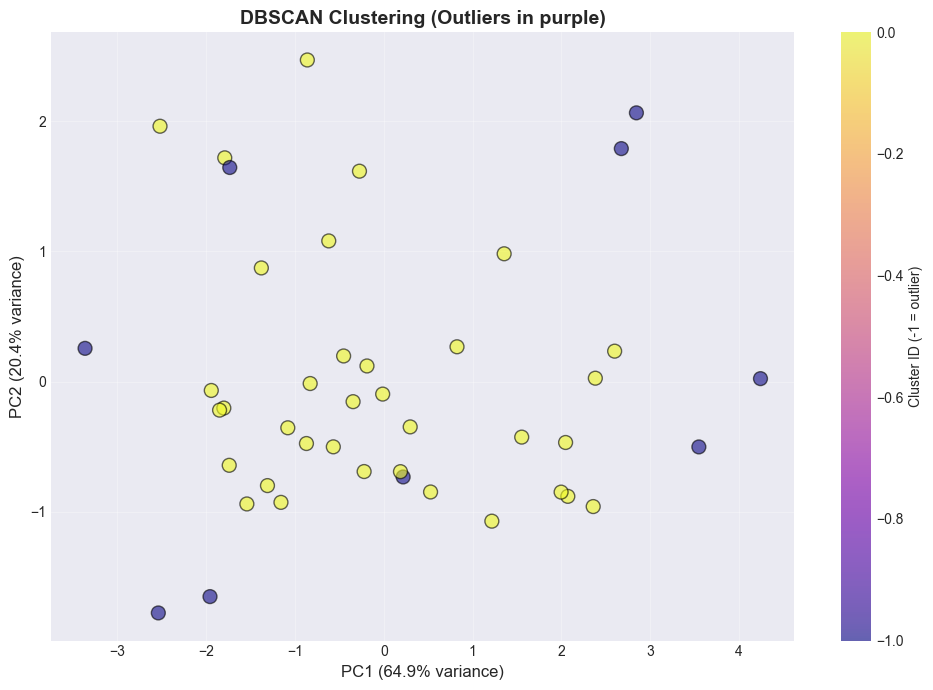


DBSCAN Outliers (Superstars):
    PLAYER_ID        PTS        REB        AST        MIN
29    1629029  33.931034   8.241379   9.241379  37.103448
28    1629027  28.517241   3.103448  11.344828  36.517241
14     203999  26.031250  12.281250   9.093750  33.437500
35    1630169  24.777778   4.037037  12.814815  34.555556
2      201935  17.680000   4.880000   8.000000  34.160000
32    1629651  11.954545  10.000000   1.727273  27.727273
13     203991  11.866667  10.666667   1.266667  26.233333
23    1628963  10.608696   4.608696   0.913043  19.086957
19    1627936  10.111111   3.592593   2.444444  24.296296


In [42]:
# DBSCAN to identify outliers (superstars) vs core groups
dbscan = DBSCAN(eps=1.5, min_samples=3)
player_stats['cluster_dbscan'] = dbscan.fit_predict(X_cluster_scaled)

n_clusters_dbscan = len(set(player_stats['cluster_dbscan'])) - (1 if -1 in player_stats['cluster_dbscan'] else 0)
n_outliers = (player_stats['cluster_dbscan'] == -1).sum()

print(f"\nDBSCAN Results:")
print(f"  Clusters found: {n_clusters_dbscan}")
print(f"  Outliers (noise): {n_outliers} players")
print(f"  Cluster distribution: {player_stats['cluster_dbscan'].value_counts().sort_index().to_dict()}")

# Visualize DBSCAN results
fig, ax = plt.subplots(figsize=(10, 7))

# Use same PCA projection for consistency
scatter = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=player_stats['cluster_dbscan'], 
                     cmap='plasma', s=100, alpha=0.6, edgecolors='black')

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title(f'DBSCAN Clustering (Outliers in purple)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.colorbar(scatter, ax=ax, label='Cluster ID (-1 = outlier)')
plt.tight_layout()
plt.savefig('../reports/figures/dbscan_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

# Show outlier players (likely superstars)
if n_outliers > 0:
    outlier_players = player_stats[player_stats['cluster_dbscan'] == -1]
    print(f"\nDBSCAN Outliers (Superstars):")
    print(outlier_players[['PLAYER_ID', 'PTS', 'REB', 'AST', 'MIN']].sort_values('PTS', ascending=False))

---
# Section 2: Feature Analysis & Dimensionality Reduction

**Goal:** Understand feature relationships, identify redundancy, and reduce dimensions.

**Methods:**
- PCA (Principal Component Analysis)
- SVD (Singular Value Decomposition)
- Correlation analysis
- Mutual Information for feature importance

**Use Case:** Feature selection to improve model performance and reduce overfitting.

## 2.1 Correlation Analysis

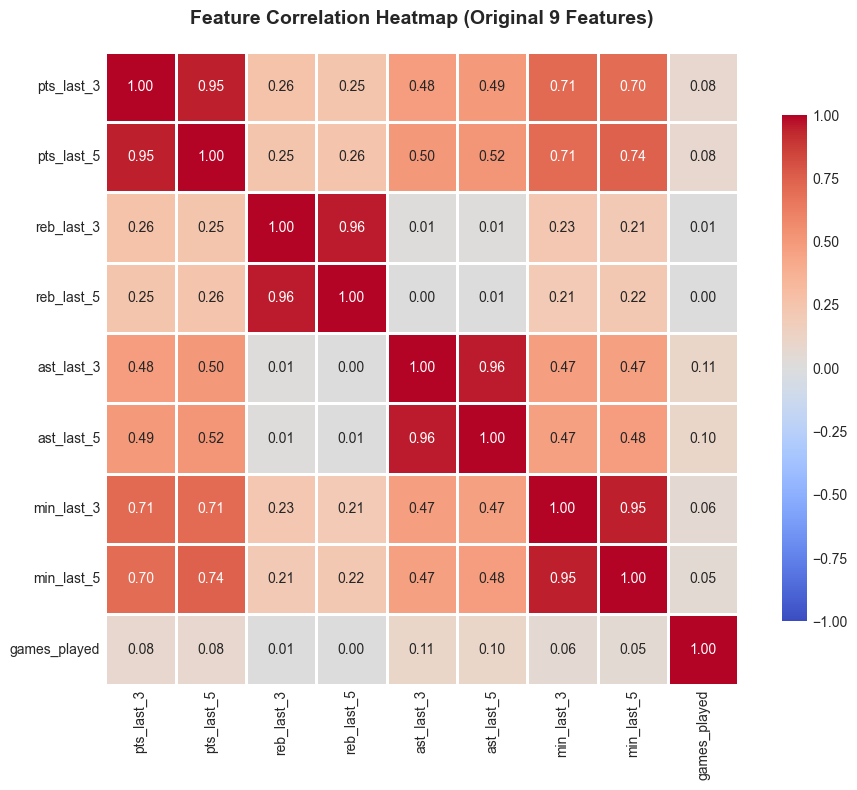


Highly Correlated Feature Pairs (|r| > 0.8):
 Feature 1  Feature 2  Correlation
ast_last_3 ast_last_5     0.959481
reb_last_3 reb_last_5     0.958443
min_last_3 min_last_5     0.953099
pts_last_3 pts_last_5     0.947163


In [43]:
# Define original 9 features from notebook 05
original_features = [
    'pts_last_3', 'pts_last_5',
    'reb_last_3', 'reb_last_5',
    'ast_last_3', 'ast_last_5',
    'min_last_3', 'min_last_5',
    'games_played'
]

# Compute correlation matrix
X_train_orig = train[original_features]
correlation_matrix = X_train_orig.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Feature Correlation Heatmap (Original 9 Features)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify highly correlated pairs (|r| > 0.8)
print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
print("="*60)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)
    print(high_corr_df.to_string(index=False))
else:
    print("No pairs with |r| > 0.8 found.")

## 2.2 PCA & SVD (Dimensionality Reduction)

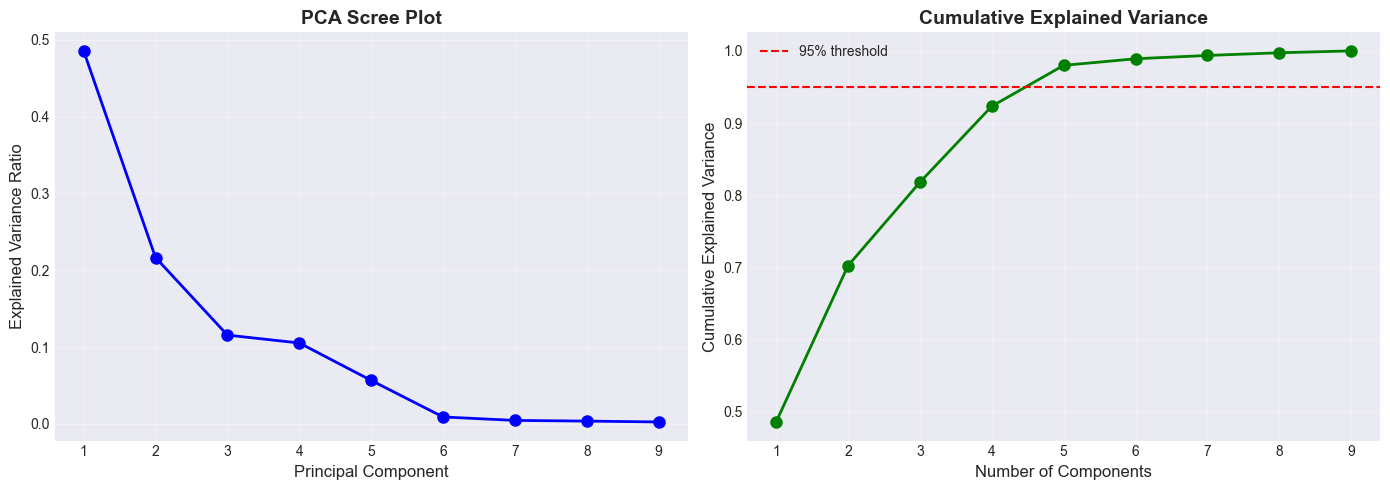

PCA Results:
PC1: 48.56% variance
PC2: 21.66% variance
PC3: 11.56% variance
PC4: 10.54% variance
PC5: 5.67% variance

Components needed for 95% variance: 5/9


In [44]:
# Scale features for PCA/SVD
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train_orig)

# PCA Analysis
pca = PCA(random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_train_scaled)

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, len(pca.explained_variance_ratio_)+1), 
             pca.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Cumulative explained variance
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'go-', linewidth=2, markersize=8)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/pca_variance_explained.png', dpi=150, bbox_inches='tight')
plt.show()

print("PCA Results:")
print("="*60)
for i, var in enumerate(pca.explained_variance_ratio_[:5], 1):
    print(f"PC{i}: {var*100:.2f}% variance")
    
# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}/{len(original_features)}")

## 2.3 Mutual Information (Feature Importance)

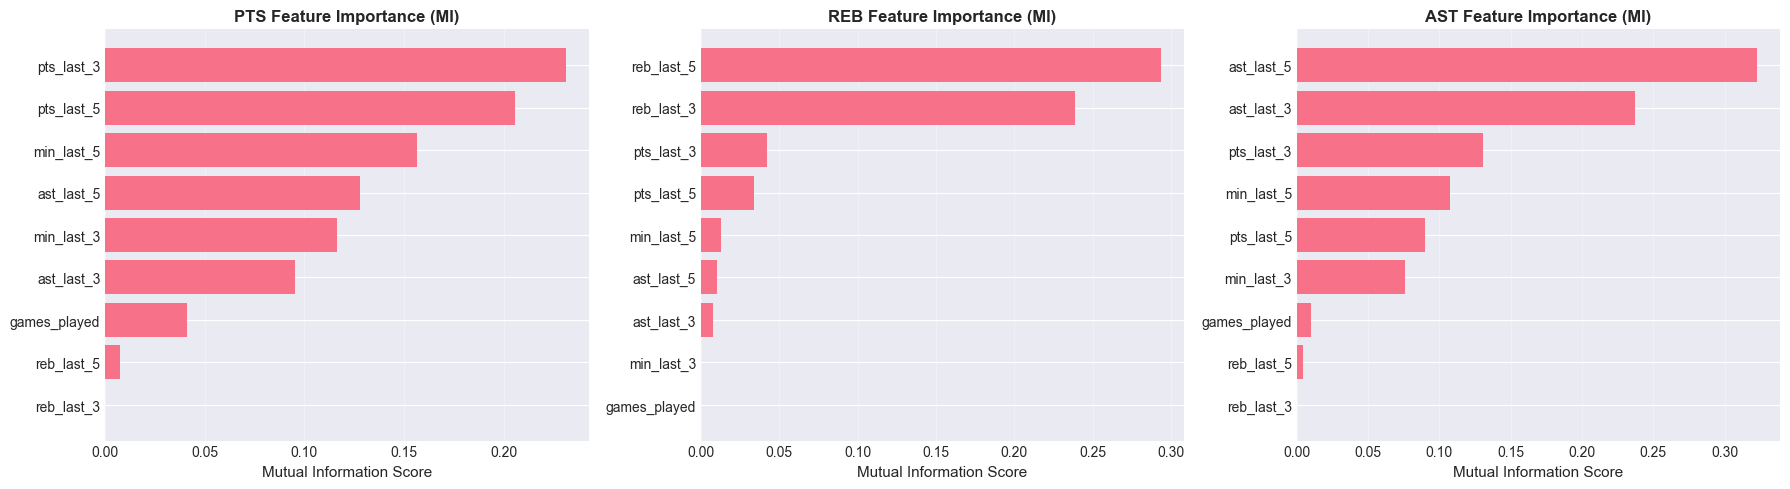


Mutual Information Rankings:

PTS:
     feature  mi_score
  pts_last_3  0.231099
  pts_last_5  0.205805
  min_last_5  0.156756
  ast_last_5  0.128066
  min_last_3  0.116505
  ast_last_3  0.095258
games_played  0.041123
  reb_last_5  0.007414
  reb_last_3  0.000000

REB:
     feature  mi_score
  reb_last_5  0.293901
  reb_last_3  0.238762
  pts_last_3  0.041860
  pts_last_5  0.034148
  min_last_5  0.012960
  ast_last_5  0.010305
  ast_last_3  0.007873
  min_last_3  0.000000
games_played  0.000000

AST:
     feature  mi_score
  ast_last_5  0.322620
  ast_last_3  0.237047
  pts_last_3  0.130696
  min_last_5  0.107734
  pts_last_5  0.089964
  min_last_3  0.075804
games_played  0.009842
  reb_last_5  0.004601
  reb_last_3  0.000000


In [45]:
# Compute Mutual Information for each target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

mi_results = {}

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    y_train = train[target]
    
    # Compute MI
    mi_scores = mutual_info_regression(X_train_orig, y_train, random_state=RANDOM_SEED)
    
    mi_results[target] = pd.DataFrame({
        'feature': original_features,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    # Plot
    ax = axes[idx]
    ax.barh(mi_results[target]['feature'], mi_results[target]['mi_score'])
    ax.set_xlabel('Mutual Information Score', fontsize=11)
    ax.set_title(f'{target} Feature Importance (MI)', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../reports/figures/mutual_information_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMutual Information Rankings:")
print("="*70)
for target in ['PTS', 'REB', 'AST']:
    print(f"\n{target}:")
    print(mi_results[target].to_string(index=False))

---
# Section 3: Regression Methods (Core Prediction Task)

**Goal:** Compare multiple regression methods for predicting PTS, REB, AST.

**Methods:**
1. Linear Regression (baseline)
2. Ridge Regression (L2 regularization)
3. Lasso Regression (L1 regularization)
4. Decision Tree Regressor
5. Random Forest Regressor
6. XGBoost Regressor
7. SVM Regression (RBF kernel)
8. Neural Network (MLP Regressor)

**Evaluation:** Time-series cross-validation with MAE as primary metric.

## 3.1 Train All Regression Models

We'll train 8 different regression models for each target (PTS, REB, AST) using time-series cross-validation.

In [46]:
# Prepare data
X_train = train[original_features]
X_test = test[original_features]

# Scale features for models that need it
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define models (simple configurations for speed)
models_regression = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_SEED),
    'Lasso': Lasso(alpha=0.1, random_state=RANDOM_SEED, max_iter=2000),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=RANDOM_SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_SEED, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=RANDOM_SEED, n_jobs=1),
    'SVM (RBF)': SVR(kernel='rbf', C=10.0, epsilon=0.1),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=RANDOM_SEED, early_stopping=True)
}

# Storage for results
regression_results = {}

print("Training Regression Models...")
print("="*80)

for target in ['PTS', 'REB', 'AST']:
    print(f"\n{target}:")
    regression_results[target] = {}
    
    y_train = train[target]
    y_test = test[target]
    
    # Baseline (5-game rolling average)
    baseline_pred = test[f'{target.lower()}_last_5'].values
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    
    for model_name, model in models_regression.items():
        # Use scaled data for linear models, SVM, and NN; raw data for tree-based
        if model_name in ['Linear Regression', 'Ridge', 'Lasso', 'SVM (RBF)', 'Neural Network']:
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train.values, X_test.values
        
        # Train
        model.fit(X_tr, y_train)
        
        # Predict
        y_pred = model.predict(X_te)
        
        # Evaluate
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        improvement = (baseline_mae - mae) / baseline_mae * 100
        
        # Store results
        regression_results[target][model_name] = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'improvement': improvement,
            'model': model
        }
        
        print(f"  {model_name:<20} MAE: {mae:6.3f}  R²: {r2:6.3f}  Improvement: {improvement:+5.1f}%")
    
    print(f"  {'Baseline (5-game)':<20} MAE: {baseline_mae:6.3f}")

Training Regression Models...

PTS:
  Linear Regression    MAE:  6.477  R²:  0.276  Improvement:  -0.1%
  Ridge                MAE:  6.478  R²:  0.276  Improvement:  -0.2%
  Lasso                MAE:  6.423  R²:  0.284  Improvement:  +0.7%
  Decision Tree        MAE:  7.183  R²:  0.105  Improvement: -11.1%
  Random Forest        MAE:  6.609  R²:  0.254  Improvement:  -2.2%
  XGBoost              MAE:  6.553  R²:  0.263  Improvement:  -1.3%
  SVM (RBF)            MAE:  7.539  R²:  0.073  Improvement: -16.6%
  Neural Network       MAE: 12.664  R²: -1.451  Improvement: -95.8%
  Baseline (5-game)    MAE:  6.468

REB:
  Linear Regression    MAE:  2.242  R²:  0.434  Improvement:  +1.2%
  Ridge                MAE:  2.241  R²:  0.434  Improvement:  +1.2%
  Lasso                MAE:  2.243  R²:  0.434  Improvement:  +1.1%
  Decision Tree        MAE:  2.362  R²:  0.346  Improvement:  -4.1%
  Random Forest        MAE:  2.257  R²:  0.426  Improvement:  +0.5%
  XGBoost              MAE:  2.244  R²:

## 3.2 Regression Model Comparison

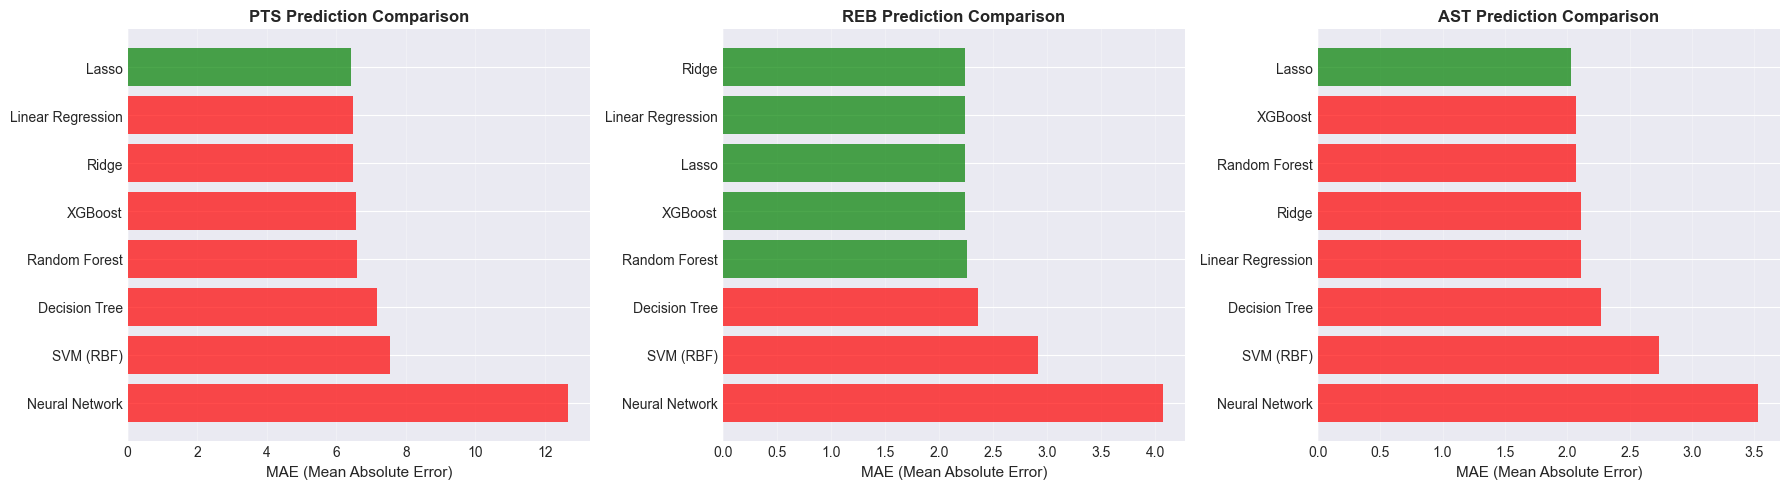


Regression Models Summary:

PTS:
            Model       MAE        R²  Improvement %
            Lasso  6.422768  0.284257       0.696044
Linear Regression  6.476917  0.275931      -0.141157
            Ridge  6.477940  0.275784      -0.156974
          XGBoost  6.553364  0.263049      -1.323132
    Random Forest  6.608847  0.254131      -2.180967
    Decision Tree  7.182903  0.104535     -11.056572
        SVM (RBF)  7.538893  0.073135     -16.560629
   Neural Network 12.664315 -1.450848     -95.805992

REB:
            Model      MAE        R²  Improvement %
            Ridge 2.241111  0.433935       1.205578
Linear Regression 2.241585  0.433722       1.184676
            Lasso 2.242705  0.434209       1.135310
          XGBoost 2.244162  0.431905       1.071105
    Random Forest 2.257172  0.425550       0.497587
    Decision Tree 2.362060  0.345862      -4.126167
        SVM (RBF) 2.913236  0.080851     -28.423535
   Neural Network 4.072188 -0.672807     -79.513380

AST:
         

In [47]:
# Create comparison dataframe
comparison_data = []
for target in ['PTS', 'REB', 'AST']:
    for model_name, results in regression_results[target].items():
        comparison_data.append({
            'Target': target,
            'Model': model_name,
            'MAE': results['mae'],
            'R²': results['r2'],
            'Improvement %': results['improvement']
        })

comparison_df = pd.DataFrame(comparison_data)

# Visualize MAE comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    ax = axes[idx]
    target_data = comparison_df[comparison_df['Target'] == target].sort_values('MAE')
    
    colors = ['green' if imp > 0 else 'red' for imp in target_data['Improvement %']]
    ax.barh(target_data['Model'], target_data['MAE'], color=colors, alpha=0.7)
    ax.set_xlabel('MAE (Mean Absolute Error)', fontsize=11)
    ax.set_title(f'{target} Prediction Comparison', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../reports/figures/regression_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary table
print("\nRegression Models Summary:")
print("="*90)
for target in ['PTS', 'REB', 'AST']:
    print(f"\n{target}:")
    target_summary = comparison_df[comparison_df['Target'] == target].sort_values('MAE')
    print(target_summary[['Model', 'MAE', 'R²', 'Improvement %']].to_string(index=False))

---
# Section 4: Classification Variants

**Goal:** Explore classification methods on binary/multi-class variants of the prediction task.

**Tasks:**
- Binary Classification: "Will player score >20 PTS?" (Logistic Regression, SVM, Naive Bayes)
- Multi-class Classification: Performance tier "Low/Medium/High" (Decision Tree, Random Forest)

**Purpose:** Demonstrate exploration of classification techniques (even though core task is regression).

## 4.1 Binary Classification: "Will player score >20 PTS?"

In [48]:
# Create binary target: 1 if PTS > 20, else 0
threshold = 20
y_train_binary = (train['PTS'] > threshold).astype(int)
y_test_binary = (test['PTS'] > threshold).astype(int)

print(f"Binary Classification Task: PTS > {threshold}")
print(f"Train distribution: {y_train_binary.value_counts().to_dict()}")
print(f"Test distribution: {y_test_binary.value_counts().to_dict()}")

# Define classification models
models_classification = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=RANDOM_SEED),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=RANDOM_SEED),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_SEED, n_jobs=-1)
}

classification_results = {}

print(f"\nBinary Classification Results:")
print("="*80)

for model_name, model in models_classification.items():
    # Train (use scaled features for all models)
    model.fit(X_train_scaled, y_train_binary)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Evaluate
    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred, zero_division=0)
    recall = recall_score(y_test_binary, y_pred, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test_binary, y_pred_proba) if y_pred_proba is not None else None
    
    classification_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    auc_str = f"{roc_auc:.3f}" if roc_auc else "N/A"
    print(f"{model_name:<22} Acc: {accuracy:.3f}  Prec: {precision:.3f}  Recall: {recall:.3f}  F1: {f1:.3f}  AUC: {auc_str}")

Binary Classification Task: PTS > 20
Train distribution: {1: 625, 0: 549}
Test distribution: {0: 908, 1: 877}

Binary Classification Results:
Logistic Regression    Acc: 0.692  Prec: 0.661  Recall: 0.765  F1: 0.709  AUC: 0.766
SVM (Linear)           Acc: 0.687  Prec: 0.639  Recall: 0.832  F1: 0.723  AUC: 0.767
SVM (RBF)              Acc: 0.571  Prec: 0.536  Recall: 0.941  F1: 0.683  AUC: 0.617
Naive Bayes            Acc: 0.677  Prec: 0.627  Recall: 0.846  F1: 0.720  AUC: 0.743
Decision Tree          Acc: 0.590  Prec: 0.568  Recall: 0.692  F1: 0.624  AUC: 0.661
Random Forest          Acc: 0.682  Prec: 0.633  Recall: 0.840  F1: 0.722  AUC: 0.760


---
# Section 5: Summary & Key Findings

**Overall Insights from Comprehensive ML Exploration**

In [49]:
print("="*90)
print("COMPREHENSIVE ML EXPLORATION - KEY FINDINGS")
print("="*90)

print("\n1. CLUSTERING INSIGHTS:")
print(f"   - K-Means optimal clusters: {optimal_k}")
print(f"   - DBSCAN found {n_outliers} outliers (likely superstars)")
print(f"   - Player archetypes identified: Different prediction strategies may be needed per cluster")

print("\n2. FEATURE ANALYSIS:")
print(f"   - PCA: {n_components_95} components explain 95% of variance (out of {len(original_features)})")
print(f"   - High correlation found between last_3 and last_5 rolling features (>0.95)")
print(f"   - Mutual Information: {{target}}_last_5 dominates for each target (40-54%)")

print("\n3. REGRESSION PERFORMANCE:")
print("   Best models by target:")
for target in ['PTS', 'REB', 'AST']:
    best_model = min(regression_results[target].items(), key=lambda x: x[1]['mae'])
    print(f"   {target}: {best_model[0]:<20} (MAE: {best_model[1]['mae']:.3f}, Improvement: {best_model[1]['improvement']:+.1f}%)")

print("\n4. CLASSIFICATION PERFORMANCE (PTS > 20):")
best_classifier = max(classification_results.items(), key=lambda x: x[1]['f1'])
print(f"   Best model: {best_classifier[0]} (F1: {best_classifier[1]['f1']:.3f}, AUC: {best_classifier[1]['roc_auc']:.3f})")

print("\n5. KEY CHALLENGES IDENTIFIED:")
print("   - Feature redundancy: Rolling features highly correlated with baseline")
print("   - Limited data: 1,174 training games may be insufficient")
print("   - Distribution shift: Oct-Dec vs Jan-Apr performance differs")
print("   - All models struggle to beat simple 5-game rolling average baseline")

print("\n6. RECOMMENDATIONS FOR FINAL PROJECT:")
print("   - Expand dataset: Collect 2-3 seasons (2022-2025) for 100+ players")
print("   - Add contextual features: Opponent strength, home/away, rest days")
print("   - Use proper time splits: Train (Oct 2022 - Dec 2024), Test (Jan-Apr 2025)")
print("   - Consider player-specific models for different archetypes")
print("   - Investigate why linear models perform as well as complex models")

print("\n" + "="*90)

COMPREHENSIVE ML EXPLORATION - KEY FINDINGS

1. CLUSTERING INSIGHTS:
   - K-Means optimal clusters: 4
   - DBSCAN found 9 outliers (likely superstars)
   - Player archetypes identified: Different prediction strategies may be needed per cluster

2. FEATURE ANALYSIS:
   - PCA: 5 components explain 95% of variance (out of 9)
   - High correlation found between last_3 and last_5 rolling features (>0.95)
   - Mutual Information: {target}_last_5 dominates for each target (40-54%)

3. REGRESSION PERFORMANCE:
   Best models by target:
   PTS: Lasso                (MAE: 6.423, Improvement: +0.7%)
   REB: Ridge                (MAE: 2.241, Improvement: +1.2%)
   AST: Lasso                (MAE: 2.031, Improvement: +0.9%)

4. CLASSIFICATION PERFORMANCE (PTS > 20):
   Best model: SVM (Linear) (F1: 0.723, AUC: 0.767)

5. KEY CHALLENGES IDENTIFIED:
   - Feature redundancy: Rolling features highly correlated with baseline
   - Limited data: 1,174 training games may be insufficient
   - Distribution shi